In [43]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statistics
import math
import pandas as pd
from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit
from scipy.integrate import simps

#from scipy.optimize import curve_fit
from matplotlib import cm,rc
#from scipy import interpolate
#from scipy.interpolate import interp1d, UnivariateSpline, CubicSpline, PchipInterpolator, Akima1DInterpolator
#import gc

In [2]:
import os
os.chdir(os.getcwd())

In [3]:
def mse_error(x, y, f, args):
    return np.sum(np.square(y - f(x, **args)))

def dS_dA(x, y, A, f, s, loc):
    # Compute the difference (y - f(x, A))
    error = y - f(x, A, s, loc)
    # Compute the derivative of f(x, A) with respect to A
    f_prime_A = (1 / (s * x * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - loc)**2 / (2 * s**2))
    # Compute the gradient dS/dA
    dS_dA = -2 * np.sum(error * f_prime_A)
    
    return dS_dA

def compute_A(x, y, s, loc):
    # Compute the numerator
    numerator = np.sum(y * (1 / (s * x * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - loc)**2 / (2 * s**2)))
    # Compute the denominator
    denominator = np.sum((1 / (s * x * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - loc)**2 / (2 * s**2)))
    # Compute A
    A = numerator / denominator
    return A
    
def weighted_std(x, w, x_bar_w):
    return np.sqrt(np.sum(w * (x - x_bar_w)**2) / ((len(x)-1) * np.sum(w) / len(x)))

def lognormal_pdf_isGISAXS(R, R0, sigma):
    return (1 / (R * np.log(sigma/R0) * np.sqrt(2 * np.pi))) * np.exp(-((np.log(R/R0) ** 2) / (np.log(sigma/R0) ** 2))/2)

def lognormal_pdf_wiki(R, R0, sigma):
    mu = R0
    return (1 / (R * sigma * np.sqrt(2 * np.pi))) * np.exp(-((np.log(R) - mu) ** 2) / (2 * (sigma ** 2)))

def lognorm_func(x, s, loc, scale=1):
    return scale/(s*x*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-loc)**2/(2*s**2))
    
def lognormal_pdf(R, R0, sigma):
    mu =np.log(R0)-(sigma**2 / 2)#R0
    return ((1 / ((R / R0) * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(R / R0) ** 2) / (2 * (sigma ** 2))))

In [4]:
def get_raw_data(path):
    with open(path,'rb') as f:
        raw_data = np.load(f)
    return raw_data

def get_thickness_values(K):
    '''function to get the known thickness values for the experiments'''
    exp_path = f'examples/fitted_experiments_whole_original_100_{K}K.npy'
    tar_path = f'examples/tar_{K}K.csv'
    exp_tar = pd.read_csv(tar_path) # read evaluation

    with open(exp_path,'rb') as f:
        a = np.load(f)
        exp_frames = np.load(f)
    exp_frames = np.transpose(exp_frames)[0] 
    exp_tar_filter = exp_tar[exp_tar.Frame.isin(exp_frames)]
    thickness_values = exp_tar_filter['thickness']
    thickness_values = np.array(thickness_values, dtype=np.float32)
    return thickness_values

def get_experiment_data(K):
    with open(f'examples/fitted_experiments_whole_original_100_{K}K.npy','rb') as f:
        exp_images = np.load(f)
        exp_tar = np.load(f)
    exp_df = pd.DataFrame(exp_tar,columns=['frame','distance','radius'])
    return exp_df.distance,exp_df.radius
        
def plot_bars(frames=range(0,310,60),save=False,label=False,flag='radius',k='100'):
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 7}
    rc('font', **font)
    
    means = np.arange(1.2,28.2,0.1) if flag=='radius' else np.arange(3.8,40.8,0.1) # flag is distance
    all_means = np.arange(0.001,28.2,0.01) if flag=='radius' else np.arange(3.8,40.8,0.1) # flag is distance

    headers = get_thickness_values(k)
    for n_frame in frames:
        plt.figure(figsize=(5,4),dpi=200)
        
        # calculating weigted average, i.e expected radius
        expected_v = 0
        for i,m in enumerate(means):
            expected_v += (raw_data[n_frame][i]*m)
            
        # printing some labels
        for i,w in enumerate(raw_data[n_frame]): 
            index_is_gt_radius = (round(means[i],1) == round(radius[n_frame],1)) if flag=='radius' else (round(means[i],1) == round(distance[n_frame],1))
            index_is_expected_radius = round(means[i],1) == round(expected_v,1) and round(expected_v,1) != round(means[np.argmax(raw_data[n_frame])],1)
            if index_is_gt_radius:
                plt.annotate(f'GT= %.1f' % means[i], xy=(means[i], 0), xytext=(means[i]+2.5,0.02),arrowprops=dict(facecolor='black', arrowstyle="->")) 
            if index_is_expected_radius:
                plt.annotate(f'Prediction= %.1f' % means[i], xy=(means[i], 0), xytext=(means[i]+5.25,0.027),arrowprops=dict(facecolor='black', arrowstyle="->")) 
                
        # ploting bars 
        plt.bar(means, raw_data[n_frame], width=0.15, label='ANN')#,lw=0.5) 

        GT = round(radius[n_frame],1) # ground truth value

        
        # calculating the lognorm distribution with sigma = 1.2 from the paper: https://pubs.aip.org/aip/apl/article/104/24/243107/384820/Silver-substrates-for-surface-enhanced-Raman
        lognorm_curve = lognorm.pdf(all_means, 1.2/radius[n_frame], scale=radius[n_frame])
        log_curve_normalized = (lognorm_curve/np.sum(lognorm_curve))
        
        # calculating the weighted standard deviation
        indices_larger_0 = raw_data[n_frame]>0.001
        stddev = np.sqrt(np.sum(raw_data[n_frame][indices_larger_0] * (means[indices_larger_0] - expected_v)**2) )# / np.sum(raw_data[n_frame][indices_larger_0]))
        #sigma = 0.1/
        # calculating the lognorm distribution with the calculated std from above
        log_curve_pred_std = lognorm.pdf(all_means, s=stddev/expected_v, scale=expected_v)
        log_curve_normalized_pred_std = (log_curve_pred_std/np.sum(log_curve_pred_std))
        log_curve_calcu = lognormal_pdf_isGISAXS(all_means, expected_v, stddev)
        log_curve_theory = lognormal_pdf_isGISAXS(all_means, radius[n_frame], 1.2)
        

        plt.plot(all_means, log_curve_theory, 'g-', lw=1, label=r'ANN $\sigma$=%.1f' %  1.2) 
        plt.plot(all_means, log_curve_calcu, 'r-', lw=1, label=r'ANN $\sigma$=%.1f' % stddev) 
     
#         plt.plot(all_means, lognorm_curve, 'k-', lw=1, label='Theory',alpha=0.6)  # plot of the calculated lognormal curve with sigma=1.2
#         plt.plot(all_means, log_curve_normalized, 'r-', lw=1, label='Theory - normalized curve')  # plot of the calculated normalized lognormal curve with sigma=1.2

#         plt.plot(all_means, log_curve_pred_std, 'g-', lw=1, label=r'ANN $\sigma$=%.1f' % stddev)  # plot of the predicted lognormal curve 
#         plt.plot(all_means, log_curve_normalized_pred_std, 'c-', lw=1, label=r'ANN - normalized $\sigma$=%.1f' % stddev) # plot of the predicted and normalized lognormal curve 

        title = r'Weights distribution and log-normal approx. with $\sigma/R = 1.2/GT$' + '\n'+ r'$\delta$ = %.1f nm' % headers[n_frame]
        plt.title(title)
        xlim = (0,28.2) if flag == 'radius'else (3.8,40.8)
        #plt.ylim((0,0.06))
        plt.ylim((0,1.2))
        plt.xlim(xlim)
        plt.ylabel('Probability')
        plt.xlabel('Radius (nm)')
        plt.legend()
        plt.show()
    

In [5]:
def plot_bars_weighted(frames=range(0,310,60),save=False,label=False,flag='radius',k='100'):
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}
    rc('font', **font)
    
    means = np.arange(1.2,28.2,0.1) if flag=='radius' else np.arange(3.8,40.8,0.1) # flag is distance
    all_means = np.arange(0.001,28.2,0.01) if flag=='radius' else np.arange(3.8,40.8,0.1) # flag is distance

    headers = get_thickness_values(k)
    for n_frame in frames:
        plt.figure(figsize=(5,4),dpi=200)
        
        # calculating weigted average, i.e expected radius
        expected_v = 0
        for i,m in enumerate(means):
            expected_v += (raw_data[n_frame][i]*m)
            
        # printing some labels
        for i,w in enumerate(raw_data[n_frame]): 
            index_is_gt_radius = (round(means[i],1) == round(radius[n_frame],1)) if flag=='radius' else (round(means[i],1) == round(distance[n_frame],1))
            index_is_expected_radius = round(means[i],1) == round(expected_v,1) and round(expected_v,1) != round(means[np.argmax(raw_data[n_frame])],1)
            if index_is_gt_radius:
                plt.annotate(f'GT= %.1f' % means[i], xy=(means[i], 0), xytext=(means[i]+2.5,0.02),arrowprops=dict(facecolor='black', arrowstyle="->")) 
            if index_is_expected_radius:
                plt.annotate(f'Prediction= %.1f' % means[i], xy=(means[i], 0), xytext=(means[i]+5.25,0.027),arrowprops=dict(facecolor='black', arrowstyle="->")) 
                
        # ploting bars 
        plt.bar(means, raw_data[n_frame], width=0.15, label='ANN')#,lw=0.5) 
        
        lnx = np.log(means)
        muhat = np.average(lnx, weights=raw_data[n_frame])
        varhat = np.average((lnx - muhat)**2, weights=raw_data[n_frame])
        shape = np.sqrt(varhat)
        scale = np.exp(muhat)

        # calculating the lognorm distribution with sigma = 1.2 from the paper: https://pubs.aip.org/aip/apl/article/104/24/243107/384820/Silver-substrates-for-surface-enhanced-Raman
        lognorm_curve = lognormal_func(means,shape,loc=muhat,scale=scale)
        log_curve_normalized = (lognorm_curve/np.sum(lognorm_curve))
     

        plt.plot(means, lognorm_curve/expected_v, 'g-', lw=1, label=r'scaled with E[X] ANN $\sigma$=%.1f' %  scale) 
        plt.plot(means, log_curve_normalized, 'r-', lw=1, label=r'Normalized ANN $\sigma$=%.1f' % scale) 
     
#         plt.plot(all_means, lognorm_curve, 'k-', lw=1, label='Theory',alpha=0.6)  # plot of the calculated lognormal curve with sigma=1.2
#         plt.plot(all_means, log_curve_normalized, 'r-', lw=1, label='Theory - normalized curve')  # plot of the calculated normalized lognormal curve with sigma=1.2

#         plt.plot(all_means, log_curve_pred_std, 'g-', lw=1, label=r'ANN $\sigma$=%.1f' % stddev)  # plot of the predicted lognormal curve 
#         plt.plot(all_means, log_curve_normalized_pred_std, 'c-', lw=1, label=r'ANN - normalized $\sigma$=%.1f' % stddev) # plot of the predicted and normalized lognormal curve 

        title = r'Weights distribution and log-normal approx.' + '\n'+ r'$\delta$ = %.1f nm' % headers[n_frame]
        plt.title(title)
        xlim = (0,28.2) if flag == 'radius'else (3.8,40.8)
        plt.ylim((0,0.06))
        plt.xlim(xlim)
        plt.ylabel('Probability')
        plt.xlabel('Radius (nm)')
        plt.legend()
        plt.show()

In [10]:
def plot_bars_jose(frames=range(0,310,60),save=False,label=False,flag='radius',k='100',mode='curve_fit'):
    font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
    rc('font', **font)
    
    means = np.arange(1.2,28.2,0.1) if flag=='radius' else np.arange(3.8,40.8,0.1) # flag is distance
    all_means = np.arange(0.01,28.2,0.01) if flag=='radius' else np.arange(3.8,40.8,0.1) # flag is distance

    headers = get_thickness_values(k)
    # Set up the grid for 2 rows and 5 columns
    fig, axs = plt.subplots(3, 2, figsize=(25, 25), dpi=300, sharey=True)  # 2 rows, 5 columns

    # Flatten the axes array to easily index into it
    axs = axs.flatten()

    # Iterate over the frames and plot into each subplot
    for idx, n_frame in enumerate(frames):
        ax = axs[idx]  # Get the current axis

        # calculating weighted average, i.e. expected radius
        expected_v = 0
        for i, m in enumerate(means):
            expected_v += (raw_data[n_frame][i] * m)

        # plotting bars
        #ax.bar(means, raw_data[n_frame], width=0.15, label='ANN')
        if mode=='curve_fit':
            # Fitting the log-normal distribution

            popt, pcov, info, _, _ = curve_fit(lognorm_func, means, raw_data[n_frame], p0=(0.2, 1, 1), full_output=True)
            print(info['nfev'])
            #y = lognorm_func(means, *popt)
            lognorm_curve = lognorm_func(means, popt[0], popt[1], 1)
            # print(y.sum())
            # integral_scaled=simps(y, means)
            # print(integral_scaled)
            # y /= integral_scaled#y.sum()

            #ax.plot(means, y, color="red", label="Fit with curve_fit")
           # ax.annotate(r'shape ($\sigma$) = %.1f' % popt[0] + '\n'+ r'location ($\mu$) = %.1f' % popt[1] +  '\n'+ r'scale ($\it{A}$) = %.1f' % popt[2], xy=(20,0.035))
            scale = popt[2]            
            #ax.bar(means, raw_data[n_frame]/scale, width=0.15, label='ANN scaled')

            textstr = '\n'.join((
                r'shape ($\sigma)=%.2f$' % (popt[0], ),
                r'location ($\mu)=%.2f$' % ( popt[1], ),
                r'scale ($\it{A})=%.2f$' % (popt[2], )))

            # # these are matplotlib.patch.Patch properties
#             props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)

#             # place a text box in upper right in axes coords
#             ax.text(20, 0.025/scale, textstr, fontsize=16,
#                     verticalalignment='top', bbox=props)

            print(f"{popt=}")

        elif mode=='weighted':
            lnx = np.log(means)
            muhat = np.average(lnx, weights=raw_data[n_frame])
            varhat = np.average((lnx - muhat)**2, weights=raw_data[n_frame])*(len(lnx)/(len(lnx)-1))
            shape = np.sqrt(varhat)
            scale = np.exp(muhat)

            # calculating the lognorm distribution with sigma = 1.2 from the paper: https://pubs.aip.org/aip/apl/article/104/24/243107/384820/Silver-substrates-for-surface-enhanced-Raman
            lognorm_curve = lognorm_func(means,shape,muhat,1)
            log_curve_normalized = (lognorm_curve/np.sum(lognorm_curve))
            textstr = '\n'.join((
                r'shape ($\sigma)=%.2f$' % (shape, ),
                r'location ($\mu)=%.2f$' % (muhat, ),
                r'scale ($\it{A})=%.2f$' % (scale, )))
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
            ax.bar(means, raw_data[n_frame], width=0.15, label='ANN scaled')

            ax.text(20, 0.035, textstr, fontsize=16,
                    verticalalignment='top', bbox=props)
            ax.plot(means, lognorm_curve, 'r-', lw=1, label=r'Fit') 
            #ax.plot(means, lognorm_curve/(expected_v*scale), 'r-', lw=1, label=r'Fit scaled with E[X]*$\sigma$') 
            #ax.plot(means, log_curve_normalized, 'k-', lw=1, label=r'Fit normalized') 
            
        elif mode=='amp_fit':
            # fitting only the scale parameter
            #zero_weights = np.zeros((len(all_means)-len(raw_data[n_frame])))
            lnx = np.log(means)
            muhat = np.average(lnx, weights=raw_data[n_frame])
            varhat = np.average((lnx - muhat)**2, weights=raw_data[n_frame])#/(len(lnx)-1)#*(len(lnx)/(len(lnx)-1))
            vs = np.sum(((lnx - muhat)**2)*raw_data[n_frame])/(len(lnx)-1)
            print(f"varhat={varhat}, vs={vs}")
            shape = np.sqrt(varhat)
            print(shape)
            #scale = np.exp(muhat)
            
            # Using lambda function as we know theshape and location (muhat)
            popt, _ = curve_fit(lambda x, a: lognorm_func(x, shape, muhat, a), means, raw_data[n_frame])
            scale = popt[0]            
            print(f"{popt=}")
            x_values = means
            # calculating the lognorm distribution with sigma = 1.2 from the paper: https://pubs.aip.org/aip/apl/article/104/24/243107/384820/Silver-substrates-for-surface-enhanced-Raman
            lognorm_curve = lognorm_func(means,shape,muhat,1)
            print(f"lognorm_curve integral = {simps(lognorm_curve, x_values)}")
            lognorm_curve_scaled = lognorm_func(means,shape,muhat,scale)
            integral_scaled=simps(lognorm_curve_scaled, x_values)
            print(f"lognorm_curve_scaled integral = {integral_scaled}")
            # using MSE
            scale_MSE = compute_A(raw_data[n_frame],lognorm_curve , shape, muhat)
            scale = scale_MSE
            print(f"scale_MSE= {scale_MSE}")

            log_curve_normalized = (lognorm_curve/np.sum(lognorm_curve))
            textstr = '\n'.join((
                r'shape ($\sigma)=%.2f$' % (shape, ),
                r'location ($\mu)=%.2f$' % (muhat, ),
                r'scale ($\it{A})=%.2f$' % (scale, )))
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)

        ax.text(20, 0.02/scale, textstr, fontsize=16,
                verticalalignment='top', bbox=props)
        ax.bar(means, raw_data[n_frame]/scale, width=0.15, label='ANN (scaled)')
        #ax.bar(means, raw_data[n_frame]/scale_MSE, width=0.15, label='ANN (scaled MSE)')

        ax.plot(means, lognorm_curve, 'r-', label=r'Fit with MLE')#Fit with curve_fit (NLS)') 
            
            #ax.plot(means, lognorm_curve_scaled, 'g-', label=r'Fit scaled') 
        # printing some labels
        for i, w in enumerate(raw_data[n_frame]):
            index_is_gt_radius = (round(means[i], 1) == round(radius[n_frame], 1)) if flag == 'radius' else (round(means[i], 1) == round(distance[n_frame], 1))
            index_is_expected_radius = round(means[i], 1) == round(expected_v, 1) and round(expected_v, 1) != round(means[np.argmax(raw_data[n_frame])], 1)
            if index_is_gt_radius:
                ax.annotate(f'GT= %.1f' % means[i], xy=(means[i], 0), xytext=(means[i]+2.3,0.01/scale), arrowprops=dict(facecolor='black', arrowstyle="->"))
            if index_is_expected_radius:
                ax.annotate(f'Prediction= %.1f' % means[i], xy=(means[i], 0), xytext=(means[i]+5.25,0.015/scale), arrowprops=dict(facecolor='black', arrowstyle="->"))


            # # If the integral is not 1, renormalize the scaled curve

       # title = r'Weights distribution and log-normal approx.' + '\n' + r'$\delta$ = %.1f nm' % headers[n_frame]
        title =  r'$\delta$ = %.1f nm' % headers[n_frame]
        ax.set_title(title)
        xlim = (0, 28.2) if flag == 'radius' else (3.8, 40.8)
        ylim = (0, 0.03/scale) if 'fit' in mode else (0,0.06)
        #ax.set_ylim(ylim)
        #ax.set_ylim((0,0.06))
        ax.set_xlim(xlim)
        
        ax.set_xlabel('Radius (nm)')
        ax.legend()
    axs[0].set_ylabel('Probability')
    # Adjust layout to avoid overlap
    fig.subplots_adjust(wspace=0, hspace=0.2)
    #plt.tight_layout()
    plt.show()

[2.5 3.  3.5 4.  4.5 5.  5.5]
varhat=0.16449667261501016, vs=0.0006115117413587665
0.4055818938451397
popt=array([0.10725783])
lognorm_curve integral = 0.9993512183549441
lognorm_curve_scaled integral = 0.10718824762623984
scale_MSE= 0.19071407363109388
varhat=0.2755323143296091, vs=0.001024283783350058
0.5249117205108008
popt=array([0.11135448])
lognorm_curve integral = 0.9959300540008597
lognorm_curve_scaled integral = 0.1109012733786368
scale_MSE= 0.14115826704726325
varhat=0.3733068408548614, vs=0.0013877577028619554
0.6109884130283171
popt=array([0.11135816])
lognorm_curve integral = 0.9894714080991781
lognorm_curve_scaled integral = 0.11018571921728988
scale_MSE= 0.12360879960796907
varhat=0.44425862225976226, vs=0.0016515191342398013
0.666527285457814
popt=array([0.11057639])
lognorm_curve integral = 0.9818774361721843
lognorm_curve_scaled integral = 0.10857246666710847
scale_MSE= 0.11541336645302876
varhat=0.5021850884306202, vs=0.0018668590367621454
0.7086501876318245
popt=arr

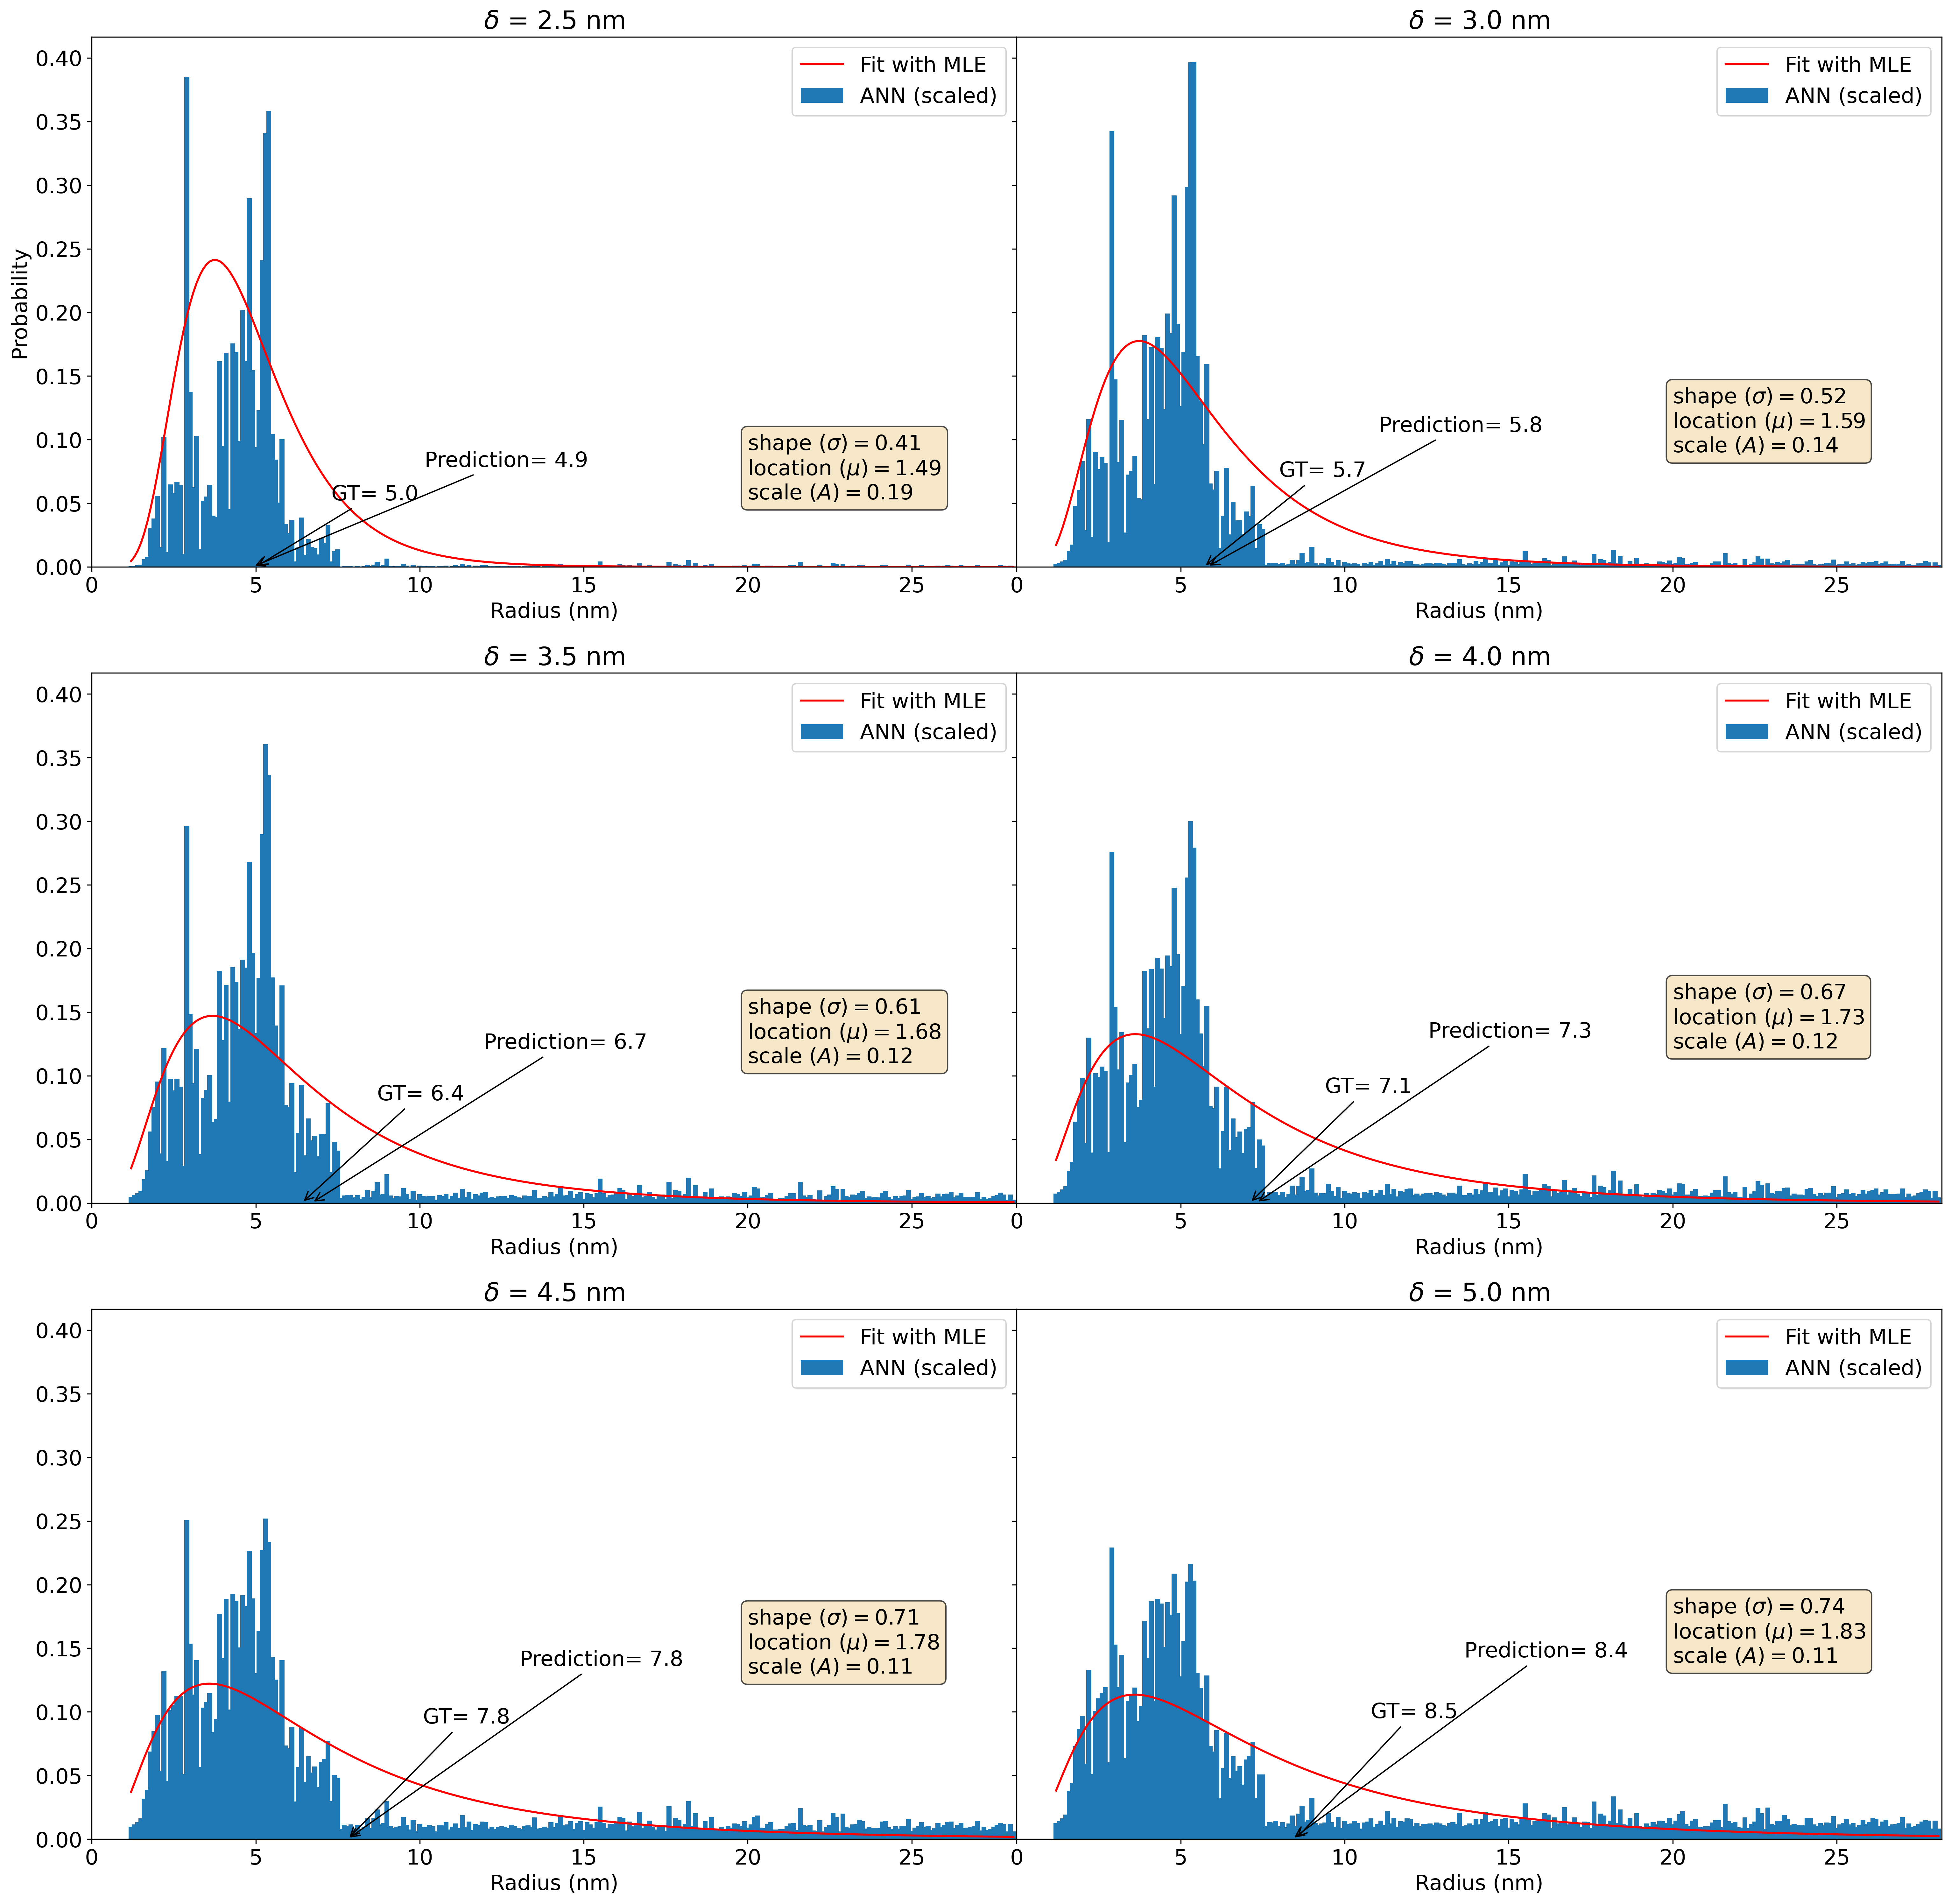

In [11]:
b75_mlplr_radius_100K = 'examples/pred_exp_100K_radius_raw_mlplr_75b.npy'  # raw output of the NN for experiment data set T = 100k
b75_mlplr_radius_500K = 'examples/pred_exp_500K_radius_raw_mlplr_75b.npy'  # raw output of the NN for experiment data set T = 500k
raw_data = get_raw_data(b75_mlplr_radius_500K)
distance,radius = get_experiment_data('500') # Those are the groud truth values I have fro the distance and radius 
headers = get_thickness_values('500')
deltas = np.arange(2.5,6.0,0.5)
#deltas = np.insert(deltas,0,1.0)
#deltas = np.sort(np.append(deltas,1.6))
print(deltas)
indices = []
for i in range(len(deltas)-1):
    try:
        indices.append(np.where((deltas[i]<=headers)&(headers<deltas[i+1]))[0][0])
    except IndexError:
        print(indices)

plot_bars_jose(frames=indices,label=False,save=False,flag='radius',k='500', mode='amp_fit')

In [42]:
keys = ['radius','sigma_radius','distance','omega_distance']
key = 'radius'
targets = {'radius':[1,2,3,4],'sigma_radius':[0.1,0.2,0.1,0.3],'distance':[3,4,5,6],'omega_distance':[0.2,0.3,0.3,0.4]}
targets_exp = {'radius':[1,2,3,4],'distance':[3,4,5,6]}
for key in keys:
    dist_key = next((dist for dist in targets_exp if "_" + key in dist), None)
    print(dist_key)
    sigmas = targets_exp[dist_key] if dist_key else None
    print(sigmas)

None
None
None
None
None
None
None
None


In [24]:
means = np.arange(1.2,28.2,0.1)
v = 0.1
m = 4.2
sigma_squared = np.log(1 + (v / m**2))
sigma = np.sqrt(sigma_squared)
mu = np.log(m) - (sigma_squared / 2)
lognorm_curve = lognorm_func(means,sigma,mu,1)
norm_curve = norm.pdf(means, loc=m, scale=v)